In [1]:
import numpy as np
import matplotlib.pyplot as plt

from distributions.sequence import Sequence
from algorithms.semi_bandit_exp3 import SemiBanditExp3

In [2]:
length = 2000
d = 2
K = 2

seq = Sequence(length=length, d=d, K=K)
seq.theta = np.ones((length, d, K))
set_to_zero = np.random.randint(K * d, size=(length))
for i in range(length):
    seq.theta[i, set_to_zero[i]//K, set_to_zero[i]%K] = 0


seq.contexts = np.zeros((length, d), dtype=int)
for i in range(length):
    seq.contexts[i, np.random.choice(d)] = 1

seq.contexts = seq.contexts / np.max(np.linalg.norm(seq.contexts, axis=1))
#seq.contexts = np.random.rand(length, d) 
seq.contexts = seq.contexts / np.max(np.linalg.norm(seq.contexts, axis=1))


In [3]:
actionset = [np.ones(K, dtype=bool)]
for i in range(K):
    buffer = np.zeros(K, dtype=bool)
    buffer[i] = 1
    actionset.append(buffer)
actionset = np.array(actionset)

optimal_policy, optimal_policy_loss = seq.find_optimal_policy(actionset)
print(optimal_policy_loss)
print(np.sum(optimal_policy_loss))

[1. 1. 1. ... 0. 1. 0.]
1469.0


In [4]:
alg = SemiBanditExp3(actionset=actionset)

# def unbiased_context_estimator(rng: np.random.Generator):
#     return np.random.rand(d) 

def unbiased_context_estimator(rng: np.random.Generator):
    result = np.zeros(d, dtype=int)
    result[rng.choice(d)] = 1
    return result

sigma = np.max(np.linalg.norm(seq.contexts, axis=1))
m = np.max(np.sum(actionset, axis=1))
lambda_min = 1/d
R = np.max(np.linalg.norm(seq.loss_sequence))

alg.set_constants(length, sigma, m, K, d, lambda_min, R, unbiased_context_estimator)
print(alg.eta, alg.gamma, alg.M)

0.0016416690868197444 0.33460223424086977 204


In [5]:
total_loss, losses = alg.run_on_sequence(alg.mgr_rng, seq)
print(total_loss, total_loss-np.sum(optimal_policy_loss))


1737.0 268.0


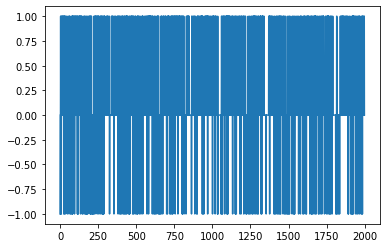

<function matplotlib.pyplot.show(*args, **kw)>

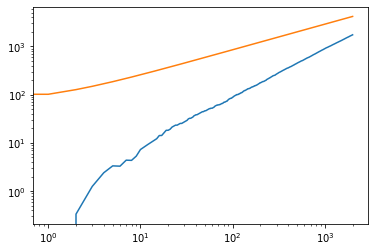

In [6]:
plt.plot(losses - optimal_policy_loss[1:])
plt.show()

def theoretical_bound(T):
    return 8 * m * np.sqrt(T * K * d * np.log(np.e * K / m) * np.log(np.sqrt(T) * m * sigma * R))

plt.loglog(np.cumsum(losses) - np.cumsum(optimal_policy_loss[1:]) / (np.arange(len(losses)) + 1))
plt.loglog(theoretical_bound(np.arange(length - 1) + 1))
plt.show